In [4]:
from pathlib import Path

from utils import get_exp_features

import numpy as np
from scipy.stats import zscore
from scipy.ndimage import uniform_filter1d
from scipy.signal.windows import cosine as cosine_filter
import matplotlib.pylab as plt

# Raw data

In [5]:
# load matlab data file
matlab_file = Path(r'./data/EphysData/A026-20200323-01.mat')
data = get_exp_features(matlab_file, downsample=25)
for k in data:
    print('loaded {}: array with shape {}'.format(k, data[k].shape))

loaded distance: array with shape (81510,)
loaded licks: array with shape (81510,)
loaded reward_on: array with shape (81510,)
loaded reward_off: array with shape (81510,)
loaded cue_on: array with shape (81510,)
loaded cue_off: array with shape (81510,)
loaded blackout_on: array with shape (81510,)
loaded blackout_off: array with shape (81510,)


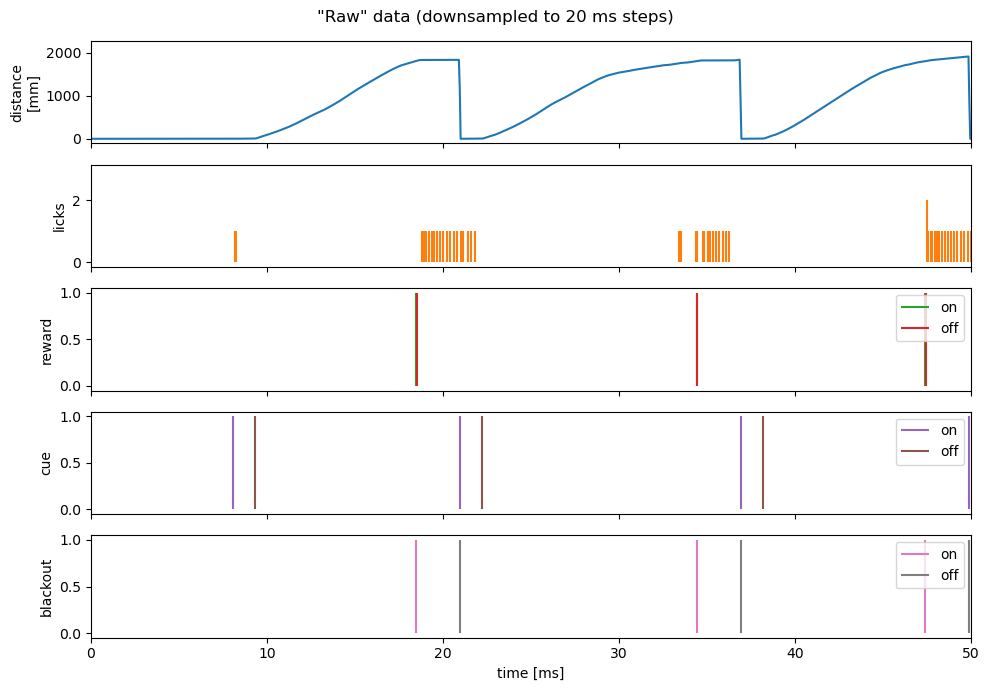

In [3]:
# plot data
fig, axarr = plt.subplots(nrows=5, figsize=(10, 7))
fig.suptitle('"Raw" data (downsampled to 20 ms steps)')
xi, xf = 0, 50

plot = lambda x: ax.plot(np.arange(len(x)) / 20, x )
vlines = lambda x, c, l: ax.vlines(np.arange(len(x)) / 20, 0, x, color=c, label=l)

ax = axarr[0]
plot(data['distance'])
ax.set_ylabel('distance\n[mm]')

ax = axarr[1]
vlines(data['licks'], 'C1', '')
ax.set_ylabel('licks')

ax = axarr[2]
vlines(data['reward_on'], 'C2', 'on')
vlines(data['reward_off'], 'C3', 'off')
ax.set_ylabel('reward')
ax.legend()

ax = axarr[3]
vlines(data['cue_on'], 'C4', 'on')
vlines(data['cue_off'], 'C5', 'off')
ax.set_ylabel('cue')
ax.legend()

ax = axarr[4]
vlines(data['blackout_on'], 'C6', 'on')
vlines(data['blackout_off'], 'C7', 'off')
ax.set_ylabel('blackout')
ax.legend()

for ax in axarr[:-1]:
    ax.set_xticklabels([])
for ax in axarr:
    ax.set_xlim(xi, xf)
ax.set_xlabel('time [ms]')

fig.tight_layout()

# Data processing 

In [7]:
# generate distance-based features, normalize and smooth

norm = lambda x: zscore(x) # normalize: subtract mean and normalize by standard deviation
smooth = lambda x, w: uniform_filter1d(x, size=w, mode='nearest')  # smooth by taking average 

# distance
dst_down = data['distance']
dst_norm = norm(dst_down)
dst = smooth(dst_norm, w=25)

# distance^2
dst2_down = dst_down**2
dst2_norm = norm(dst2_down)
dst2 = smooth(dst2_norm, w=25)

# distance^3
dst3_down = dst_down**3
dst3_norm = norm(dst3_down)
dst3 = smooth(dst3_norm, w=25)

# velocity
vel_down = np.clip(np.round(np.diff(dst_down, prepend=dst_down[1] - dst_down[0]), 5), 0, np.inf) # TODO plot features/rewrite
vel_norm = norm(vel_down)
vel = smooth(vel_norm, w=25)

# acceleration
acc_down = np.round(np.diff(vel_down, prepend=vel_down[1]-vel_down[0]), 5) # TODO plot features/rewrite
acc_norm = norm(acc_down)
acc = smooth(acc_norm, w=25)

# convolve time-event features with raised cosines

convolve = lambda x, w: np.convolve(x, cosine_filter(w), mode='same') # convolve with cosine

# licks
lck_train = data['licks']
lck_conv = convolve(lck_train, w=7) # orig: w=13)

# rewards 
rwd_train = data['reward_on'] # ignoring reward off for now
rwd_conv = convolve(rwd_train, w=13)

# cues
cue_on_train = data['cue_on']
cue_on_conv = convolve(cue_on_train, w=13) # orig: w=26)
cue_off_train = data['cue_off']
cue_off_conv = convolve(cue_off_train, w=13) # orig: w=26)

# blackouts
blk_on_train = data['blackout_on']
blk_on_conv = convolve(blk_on_train, w=13) # orig: w=26)
blk_off_train = data['blackout_off']
blk_off_conv = convolve(blk_off_train, w=13) # orig: w=26)

# spikes
# TODO


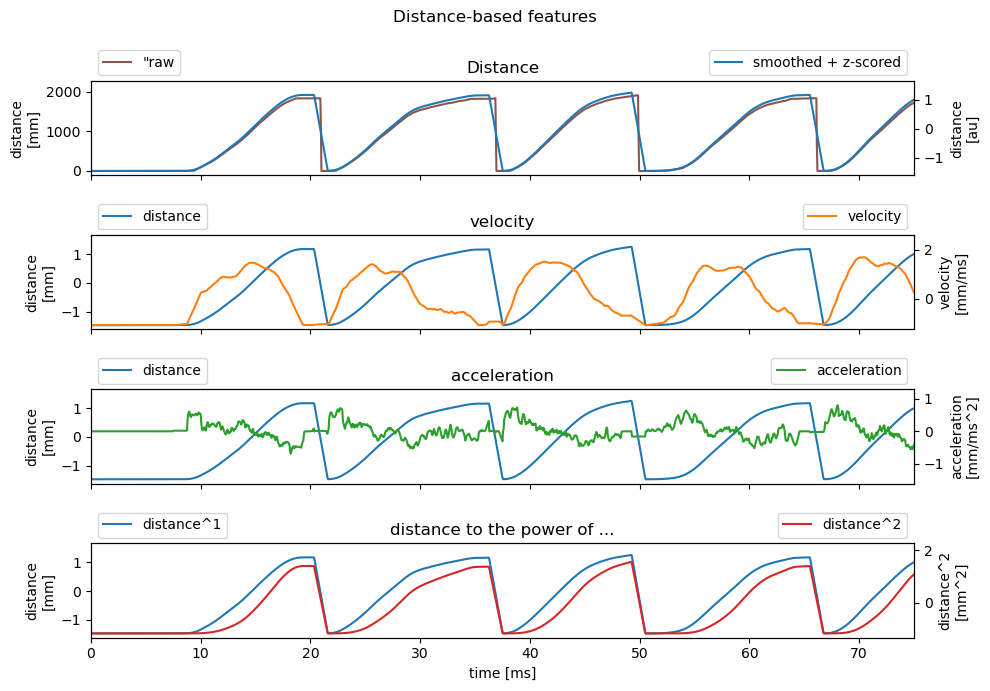

In [11]:
# plot distance and related features
fig, axarr = plt.subplots(nrows=4, figsize=(10, 7))
fig.suptitle('Distance-based features')
xi, xf = 0, 75

line = lambda x, l, c: ax.plot(np.arange(len(x)) / 20, x, label=l, color=c, zorder=-99)
lo = 1.4

ax = axarr[0]
ax.set_title('Distance')
line(dst_down, '"raw', 'C5')
ax.set_ylabel('distance\n[mm]')
ax.legend(loc='upper left', bbox_to_anchor=(0, lo))

ax = ax.twinx()
line(dst, 'smoothed + z-scored', 'C0')
ax.set_ylabel('distance\n[au]')
ax.legend(loc='upper right', bbox_to_anchor=(1, lo))


ax = axarr[1]
ax.set_title('velocity')
line(dst, 'distance', 'C0')
ax.legend(loc='upper left', bbox_to_anchor=(0, lo))
ax.set_ylabel('distance\n[mm]')

ax = ax.twinx()
line(vel, 'velocity', 'C1')
ax.legend(loc='upper right', bbox_to_anchor=(1, lo))
ax.set_ylabel('velocity\n[mm/ms]')

ax = axarr[2]
ax.set_title('acceleration')
line(dst, 'distance', 'C0')
ax.legend(loc='upper left', bbox_to_anchor=(0, lo))
ax.set_ylabel('distance\n[mm]')

ax = ax.twinx()
line(acc, 'acceleration', 'C2')
ax.legend(loc='upper right', bbox_to_anchor=(1, lo))
ax.set_ylabel('acceleration\n[mm/ms^2]')


ax = axarr[3]
ax.set_title('distance to the power of ...')
line(dst, 'distance^1', 'C0')
ax.legend(loc='upper left', bbox_to_anchor=(0, lo))
ax.set_ylabel('distance\n[mm]')

ax = ax.twinx()
line(dst2, 'distance^2', 'C3')
ax.legend(loc='upper right', bbox_to_anchor=(1, lo))
ax.set_ylabel('distance^2\n[mm^2]')

for ax in axarr:
    ax.set_xlim(xi, xf)
for ax in axarr[:-1]:
    ax.set_xticklabels([])
ax = axarr[-1]
ax.set_xlabel('time [ms]')

fig.tight_layout()

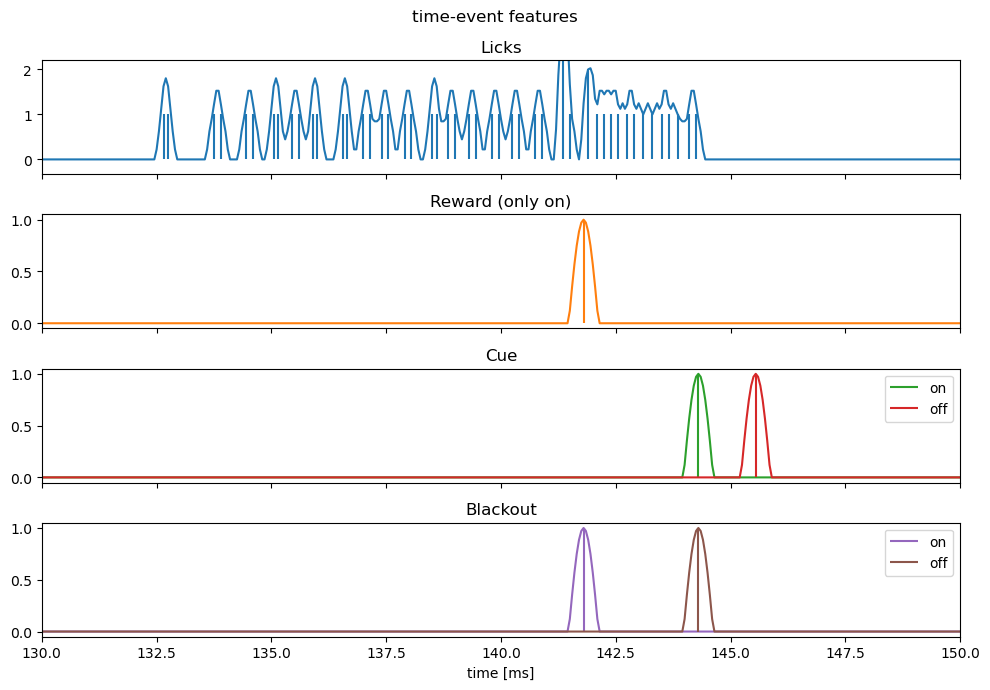

In [17]:
# plot time-event features and convolutions
fig, axarr = plt.subplots(nrows=4, figsize=(10, 7))
fig.suptitle('time-event features')
xi, xf = 130, 150

line = lambda x, l, c: ax.plot(np.arange(len(x)) / 20, x, label=l, color=c, zorder=-99)
vlines = lambda x, l, c: ax.vlines(np.arange(len(x)) / 20, 0, x, label=l, color=c, zorder=-99)
lo = 1.4

ax = axarr[0]
ax.set_title('Licks')
vlines(lck_train, 'licks', 'C0')
line(lck_conv, 'raised cosines', 'C0')
ax.set_ylim(top=2.2)

ax = axarr[1]
ax.set_title('Reward (only on)')
vlines(rwd_train, 'reward', 'C1')
line(rwd_conv, 'raised cosines', 'C1')

ax = axarr[2]
ax.set_title('Cue')
vlines(cue_on_train, 'on', 'C2')
line(cue_on_conv, '', 'C2')
vlines(cue_off_train, 'off', 'C3')
line(cue_off_conv, '', 'C3')
ax.legend()

ax = axarr[3]
ax.set_title('Blackout')
vlines(blk_on_train, 'on', 'C4')
line(blk_on_conv, '', 'C4')
vlines(blk_off_train, 'off', 'C5')
line(blk_off_conv, '', 'C5')
ax.legend()

for ax in axarr:
    ax.set_xlim(xi, xf)
for ax in axarr[:-1]:
    ax.set_xticklabels([])
ax = axarr[-1]
ax.set_xlabel('time [ms]')

fig.tight_layout()